<a href="https://colab.research.google.com/github/ggrotewold/FluShot/blob/main/FluShot_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Feature-cleansing
prepare features for training






In [2]:
# load features from google.drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# convert objects in to label-encoded values
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd

training_features = pd.read_csv('/content/drive/My Drive/FluShotData/training_set_features.csv')
training_features = training_features.set_index('respondent_id')
training_labels = pd.read_csv('/content/drive/My Drive/FluShotData/training_set_labels.csv')
training_labels = training_labels.set_index('respondent_id')
training_features.describe()

class SetCatType(TransformerMixin):
    def fit(self, X):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.astype('category')

class FillMissingCatValues(TransformerMixin):
  def fit(self, X):
    return self
  def transform(self, X):
    assert isinstance(X, pd.DataFrame)
    X = X.fillna('missing')
    return X

class DataFrameEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return pd.get_dummies(X, drop_first=False).copy()

class NumericTransformer(TransformerMixin):
    def fit(self, X, y=None):
        self.mean= X.iloc[0:].mean(axis=0, skipna=True, numeric_only=True)
        self.min = X.iloc[0:].min(axis=0)
        self.max = X.iloc[0:].max(axis=0)
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        X = X.fillna(self.mean)
        X = (X-self.min)/(self.max-self.min)
        X = X * (self.max-self.min) + self.min
        return X

class PreparationPipeline(TransformerMixin):
  def __init__(self, cat_labels, num_labels, cat_pipeline, num_pipeline):
    self.cat_labels = cat_labels
    self.num_labels = num_labels
    self.cat_pipeline = cat_pipeline
    self.num_pipeline = num_pipeline
    return

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    assert isinstance(X, pd.DataFrame)
    data_numeric_prepared = self.num_pipeline.fit_transform(X[self.num_labels])
    data_category_prepared = self.cat_pipeline.fit_transform(X[self.cat_labels])
    return pd.concat([data_numeric_prepared, data_category_prepared], axis=1)
               

# pipeline for numeric-values
numeric_pipeline = Pipeline([
                             ('fillnans', NumericTransformer()),
])


# pipeline for category-values
category_pipeline = Pipeline([
                              ('fillnans', FillMissingCatValues()),
                              ('setcat', SetCatType()),
                              ('encoder', DataFrameEncoder()),
])  


# Prepare data
category_labels = ['h1n1_concern','h1n1_knowledge','doctor_recc_h1n1','doctor_recc_seasonal',
                   'chronic_med_condition','health_worker','health_insurance','opinion_h1n1_vacc_effective',
                   'opinion_h1n1_risk','opinion_h1n1_sick_from_vacc','opinion_seas_vacc_effective',
                   'opinion_seas_risk','opinion_seas_sick_from_vacc','age_group','race','employment_status', 'sex', 'income_poverty']
numeric_labels = ['household_children', 'household_adults']

training_features.head()

preparation_pipeline = PreparationPipeline(category_labels, numeric_labels, category_pipeline, numeric_pipeline)
prepared_data = preparation_pipeline.fit_transform(training_features)

# prepration of features finished: Split in validation-set and training-set
training_features, validation_features, training_labels, validation_labels = train_test_split(prepared_data, training_labels, test_size=0.2, random_state=42)

prepared_data.head()

,household_children,household_adults,h1n1_concern_0.0,h1n1_concern_1.0,h1n1_concern_2.0,h1n1_concern_3.0,h1n1_concern_missing,h1n1_knowledge_0.0,h1n1_knowledge_1.0,h1n1_knowledge_2.0,h1n1_knowledge_missing,doctor_recc_h1n1_0.0,doctor_recc_h1n1_1.0,doctor_recc_h1n1_missing,doctor_recc_seasonal_0.0,doctor_recc_seasonal_1.0,doctor_recc_seasonal_missing,chronic_med_condition_0.0,chronic_med_condition_1.0,chronic_med_condition_missing,health_worker_0.0,health_worker_1.0,health_worker_missing,health_insurance_0.0,health_insurance_1.0,health_insurance_missing,opinion_h1n1_vacc_effective_1.0,opinion_h1n1_vacc_effective_2.0,opinion_h1n1_vacc_effective_3.0,opinion_h1n1_vacc_effective_4.0,opinion_h1n1_vacc_effective_5.0,opinion_h1n1_vacc_effective_missing,opinion_h1n1_risk_1.0,opinion_h1n1_risk_2.0,opinion_h1n1_risk_3.0,opinion_h1n1_risk_4.0,opinion_h1n1_risk_5.0,opinion_h1n1_risk_missing,opinion_h1n1_sick_from_vacc_1.0,opinion_h1n1_sick_from_vacc_2.0,...,opinion_h1n1_sick_from_vacc_4.0,opinion_h1n1_sick_from_vacc_5.0,opinion_h1n1_sick_from_vacc_missing,opinion_seas_vacc_effective_1.0,opinion_seas_vacc_effective_2.0,opinion_seas_vacc_effective_3.0,opinion_seas_vacc_effective_4.0,opinion_seas_vacc_effective_5.0,opinion_seas_vacc_effective_missing,opinion_seas_risk_1.0,opinion_seas_risk_2.0,opinion_seas_risk_3.0,opinion_seas_risk_4.0,opinion_seas_risk_5.0,opinion_seas_risk_missing,opinion_seas_sick_from_vacc_1.0,opinion_seas_sick_from_vacc_2.0,opinion_seas_sick_from_vacc_3.0,opinion_seas_sick_from_vacc_4.0,opinion_seas_sick_from_vacc_5.0,opinion_seas_sick_from_vacc_missing,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,race_Black,race_Hispanic,race_Other or Multiple,race_White,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,employment_status_missing,sex_Female,sex_Male,"income_poverty_<= $75,000, Above Poverty","income_poverty_> $75,000",income_poverty_Below Poverty,income_poverty_missing
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
1,0.0,0.0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0
2,0.0,2.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0
3,0.0,0.0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0
4,0.0,1.0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0


In [7]:
prepared_data.shape

(26707, 81)

## Create tensor-flow NN

In [9]:
import tensorflow as tf
from tensorflow import keras



# create model
def model_factory(_optimizer=tf.optimizers.SGD(learning_rate=0.001), _activation = keras.activations.sigmoid, num_hidden_layers=1, num_neurons = 50):
  model = keras.models.Sequential()
  model.add(keras.Input((81,)))
  model.add(keras.layers.Dense(81, activation=_activation, name='input_layer', kernel_regularizer=None))
  for layer in range(num_hidden_layers):
    model.add(keras.layers.Dense(num_neurons,  activation=_activation, name='hidden_layer_'+ str(layer), kernel_regularizer=None))
  model.add(keras.layers.Dense(2,   activation=_activation, name='output_layer'))
  model.build(74)
  model.compile(_optimizer, loss='binary_crossentropy', metrics=['AUC'])
  return model 


keras_regr = keras.wrappers.scikit_learn.KerasRegressor(model_factory)




## FIT

In [26]:
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

def lr_time_based_decay(epoch, lr):
  return lr * 1 / (1 + decay * epoch)

initial_learning_rate = 0.01
_epochs =1500
decay = initial_learning_rate / _epochs

param_distribution = {
    'num_neurons' : [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], # this needs to be done in this way (range can not be used) because of bug in sklearn
    'num_hidden_layers' : [1,2],
}

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')


rmd_search_cv = RandomizedSearchCV(keras_regr, param_distribution, n_jobs=-1, n_iter = 11, cv=2, verbose=10)
rmd_search_cv.fit(training_features,
                  training_labels,
                  epochs=_epochs,
                  validation_data = (validation_features, validation_labels),
                  verbose=0, 
                  callbacks=[keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose=0), early_stopping_cb]
                  )

model = rmd_search_cv.best_estimator_.model
parameters = rmd_search_cv.best_params_
model.save('/content/drive/My Drive/FluShotData/FluShot_best_estimator.h5')

print('best score:')
print(rmd_search_cv.best_score_)
print('best params:')
print(parameters)

Fitting 2 folds for each of 11 candidates, totalling 22 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 55.9min
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed: 80.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed: 80.2min finished


best score:
-0.46056240797042847
best params:
{'num_neurons': 35, 'num_hidden_layers': 1}


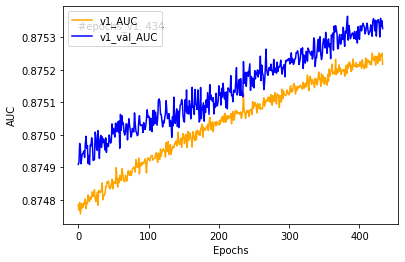

In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def lr_time_based_decay(epoch, lr):
  return lr * 1 / (1 + decay * epoch)

initial_learning_rate = 0.001
_epochs =20000
decay = initial_learning_rate / _epochs

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_auc', patience=50, restore_best_weights=True, mode='max')
checkpoint_cb = keras.callbacks.ModelCheckpoint('flu_shot_model_v1.h5', save_best_only=True)

model = keras.models.load_model('/content/drive/My Drive/FluShotData/FluShot_best_estimator.h5')

# fit model
history = model.fit(training_features, 
                    training_labels, epochs=_epochs, 
                    validation_data=(validation_features,validation_labels), 
                    verbose=0, 
                    callbacks=[keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose=0), checkpoint_cb, early_stopping_cb])
epoch_max = len(history.history['loss'])

model.save('/content/drive/My Drive/FluShotData/FluShot_best_estimator.h5')

plt.plot(history.history['auc'], label='v1_AUC', color='orange')
plt.plot(history.history['val_auc'], label='v1_val_AUC', color='b')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.text(0,history.history['val_auc'][epoch_max-1], '#epochs_v1: '+ str(epoch_max))
plt.legend()

plt.show()

In [23]:
history.history['val_auc'][epoch_max-1]

0.8753267526626587

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 81)                6642      
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 35)                2870      
_________________________________________________________________
output_layer (Dense)         (None, 2)                 72        
Total params: 9,584
Trainable params: 9,584
Non-trainable params: 0
_________________________________________________________________


## PREDICT

In [25]:
from datetime import datetime

def competitionOutput(filenameIn, filenameOut,model):
    # prepare competition features
    competition_features = pd.read_csv(filenameIn)
    competition_features_cleaned = preparation_pipeline.transform(competition_features)
    competition_prediction = model.predict(competition_features_cleaned)
    
    competition_result = competition_features
    competition_result['h1n1_vaccine'] = competition_prediction[:,0]
    competition_result['seasonal_vaccine'] = competition_prediction[:,1]
    competition_result = competition_result[['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine']]
    
    #create output csv
    competition_result.to_csv(filenameOut, index=False)
    return competition_result




try:
    model = keras.models.load_model('/content/drive/My Drive/FluShotData/FluShot_best_estimator.h5')
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor='auc', patience=50, restore_best_weights=True, mode='max')
    # train model with validation-features, too
    model.fit(validation_features,validation_labels, epochs=20000, 
                    verbose=5, 
                    callbacks=[early_stopping_cb])
    model.save('FluShot_best_estimator_with_validation_data.h5')

    #predict and create competition-result
    competition_output = competitionOutput('/content/drive/My Drive/FluShotData/test_set_features.csv', '/content/drive/My Drive/FluShotData/FluShot_result.csv', model)
    print('competition output created')
    competition_output.head()
except NameError:
   # Do nothing.
    print('Errors')



Epoch 1/20000
Epoch 2/20000
Epoch 3/20000
Epoch 4/20000
Epoch 5/20000
Epoch 6/20000
Epoch 7/20000
Epoch 8/20000
Epoch 9/20000
Epoch 10/20000
Epoch 11/20000
Epoch 12/20000
Epoch 13/20000
Epoch 14/20000
Epoch 15/20000
Epoch 16/20000
Epoch 17/20000
Epoch 18/20000
Epoch 19/20000
Epoch 20/20000
Epoch 21/20000
Epoch 22/20000
Epoch 23/20000
Epoch 24/20000
Epoch 25/20000
Epoch 26/20000
Epoch 27/20000
Epoch 28/20000
Epoch 29/20000
Epoch 30/20000
Epoch 31/20000
Epoch 32/20000
Epoch 33/20000
Epoch 34/20000
Epoch 35/20000
Epoch 36/20000
Epoch 37/20000
Epoch 38/20000
Epoch 39/20000
Epoch 40/20000
Epoch 41/20000
Epoch 42/20000
Epoch 43/20000
Epoch 44/20000
Epoch 45/20000
Epoch 46/20000
Epoch 47/20000
Epoch 48/20000
Epoch 49/20000
Epoch 50/20000
Epoch 51/20000
Epoch 52/20000
Epoch 53/20000
Epoch 54/20000
Epoch 55/20000
Epoch 56/20000
Epoch 57/20000
Epoch 58/20000
Epoch 59/20000
Epoch 60/20000
Epoch 61/20000
Epoch 62/20000
Epoch 63/20000
Epoch 64/20000
Epoch 65/20000
Epoch 66/20000
Epoch 67/20000
Epoc